In [4]:
''' import libraries '''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import ase
import warnings
from mpl_toolkits import mplot3d
from ase.build import bulk
import pycce.filter
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib as mpl

import time

"""set up seed for bath generations"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=10)

No handles with labels found to put in legend.
C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:172: RuntimeWarning: overflow encountered in power
  vcalc = contribution_operator(vcalc, current_power[index])
C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:174: RuntimeWarning: invalid value encountered in multiply
  result = result_operator(result, vcalc)
No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

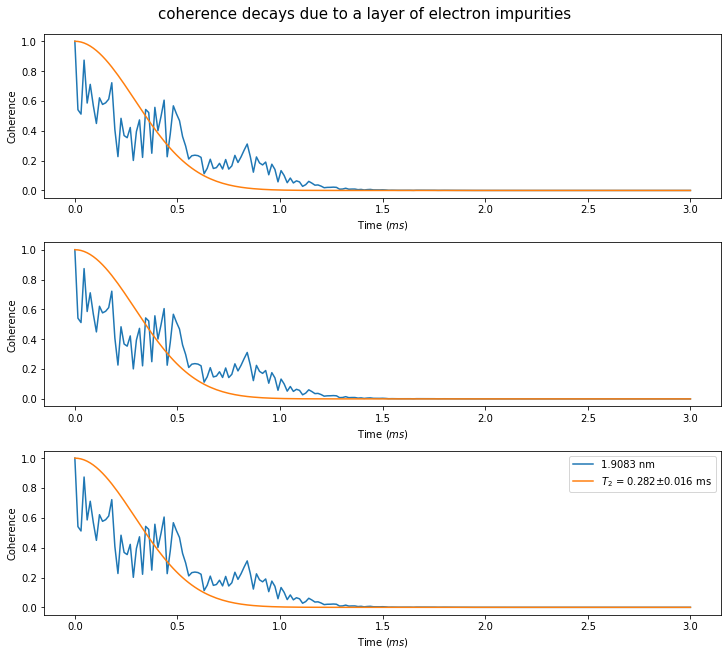

In [82]:
''' import libraries '''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import ase
import warnings
from mpl_toolkits import mplot3d
from ase.build import bulk
import pycce.filter
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib as mpl

"""set up seed for bath generations"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=10)


# plt.style.use('plot_style.txt')
mpl.rcParams['figure.figsize'] = [10.0, 9.0]
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['axes.labelsize'] = 10.0

plt.figure()
fig, axes = plt.subplots(3,1, constrained_layout = True)
fig.suptitle('coherence decays due to a layer of electron impurities', size=15)


#######################################################################################################################
########## depth = 8.0917 nm ##########
#######################################################################################################################

''' generate layer of 10 electrons within a thin 10x10x1 nm^3 layer '''
electron_10_sparse = pc.random_bath('e', [1e2, 1e2, 10], density=1e20,
                        density_units='cm-3', center=[50,50,60], seed=seed)


''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [5, 5, 5]),
                                               ('C', [5+0.5, 5+0.5, 5+0.5])],
                                  add=('14N', [5+0.5, 5+0.5, 5+0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 150  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [5,5,5]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_10_sparse]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_far = []
l_generatilze_fixed_far = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25:
        l_generatilze_fixed_far.append(l_generatilze_test[i])
        time_space_generatilze_fixed_far.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_far,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_far, l_generatilze_fixed_far)
T2_var_far = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_far = coherence_fit(time_space_generatilze_fixed_far, T2_gen_far)

axes[0].plot(time_space_generatilze_fixed_far, l_generatilze_fixed_far, label='8.092 nm', ls='-')
axes[0].plot(time_space_generatilze_fixed_far, y_gen_far, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_far[0],T2_var_far[0][0]))
axes[0].set_xlabel('Time ($ms$)')
axes[0].set_ylabel('Coherence')
axes[0].legend()


#######################################################################################################################
########## depth = 5 nm ##########
#######################################################################################################################

''' generate layer of 10 electrons within a thin 10x10x1 nm^3 layer '''
electron_10_sparse = pc.random_bath('e', [1e2, 1e2, 10], density=1e20,
                        density_units='cm-3', center=[50,50,60], seed=seed)


''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [0, 0, 0]),
                                               ('C', [0+0.5, 0+0.5, 0+0.5])],
                                  add=('14N', [0+0.5, 0+0.5, 0+0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 150  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [0,0,0]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_10_sparse]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_mid = []
l_generatilze_fixed_mid = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25:
        l_generatilze_fixed_mid.append(l_generatilze_test[i])
        time_space_generatilze_fixed_mid.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_mid,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_mid, l_generatilze_fixed_mid)
T2_var_mid = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_mid = coherence_fit(time_space_generatilze_fixed_mid, T2_gen_mid)

axes[1].plot(time_space_generatilze_fixed_mid, l_generatilze_fixed_mid, label='5.0 nm', ls='-')
axes[1].plot(time_space_generatilze_fixed_mid, y_gen_mid, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_mid[0],T2_var_mid[0][0]))
axes[1].set_xlabel('Time ($ms$)')
axes[1].set_ylabel('Coherence')
axes[1].legend()


#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################


''' generate layer of 10 electrons within a thin 10x10x1 nm^3 layer '''
electron_10_sparse = pc.random_bath('e', [1e2, 1e2, 10], density=1e20,
                        density_units='cm-3', center=[50,50,60], seed=seed)


''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [-5, -5, -5]),
                                               ('C', [-5+0.5, -5+0.5, -5+0.5])],
                                  add=('14N', [-5+0.5, -5+0.5, -5+0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 150  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [-5,-5,-5]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_10_sparse]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_near = []
l_generatilze_fixed_near = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25:
        l_generatilze_fixed_near.append(l_generatilze_test[i])
        time_space_generatilze_fixed_near.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_near,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_near, l_generatilze_fixed_near)
T2_var_near = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_near = coherence_fit(time_space_generatilze_fixed_near, T2_gen_near)

axes[2].plot(time_space_generatilze_fixed_near, l_generatilze_fixed_near, label='1.9083 nm', ls='-')
axes[2].plot(time_space_generatilze_fixed_near, y_gen_near, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_near[0],T2_var_near[0][0]))
axes[2].set_xlabel('Time ($ms$)')
axes[2].set_ylabel('Coherence')
axes[2].legend()

### varying concentration from 10 to 200 

In [ ]:
plt.style.use('plot_style.txt')
conc = np.arange(1e20,2.1e21,1e20)
num = np.arange(10,301,10)


#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################
T2_H_near = []
T2_err_H_near = []
for j in conc:
    ''' generate layer of 10-200 hydrogens within a thin 10x10x1 nm^3 layer '''
    hydrogen_layer = pc.random_bath('1H', [1e2, 1e2, 10], 
                                        density=j, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [-5, -5, -5]),('C', [-5+0.5, -5+0.5, -5+0.5])],
                                  add=('14N', [-5+0.5, -5+0.5, -5+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [-5,-5,-5]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,hydrogen_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 3, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_H_near.append(T2_gen[0])
    T2_err_H_near.append(T2_var[0][0])
    
#######################################################################################################################
########## depth = 5.0 nm ##########
#######################################################################################################################
T2_H_mid = []
T2_err_H_mid = []
for j in conc:
    ''' generate layer of 10-300 hydrogens within a thin 10x10x1 nm^3 layer '''
    hydrogen_layer = pc.random_bath('1H', [1e2, 1e2, 10], 
                                        density=j, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [0, 0, 0]),('C', [0+0.5, 0+0.5, 0+0.5])],
                                  add=('14N', [0+0.5, 0+0.5, 0+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [0,0,0]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,hydrogen_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 3, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_H_mid.append(T2_gen[0])
    T2_err_H_mid.append(T2_var[0][0])

#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################
T2_H_far = []
T2_err_H_far = []
for j in conc:
    ''' generate layer of 10-300 hydrogens within a thin 10x10x1 nm^3 layer '''
    hydrogen_layer = pc.random_bath('1H', [1e2, 1e2, 10], 
                                        density=j, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [5, 5, 5]),('C', [5+0.5, 5+0.5, 5+0.5])],
                                  add=('14N', [5+0.5, 5+0.5, 5+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [5,5,5]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,hydrogen_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 3, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_H_far.append(T2_gen[0])
    T2_err_H_far.append(T2_var[0][0])

# plots the data points and the fitted  curve
plt.figure()
plt.errorbar(num, T2_H_near, yerr=T2_err_H_near, label='1.9083 nm', ls='x-')
plt.errorbar(num, T2_H_mid , yerr=T2_err_H_mid , label='5.0 nm', ls='.-')
plt.errorbar(num, T2_H_far , yerr=T2_err_H_far , label='8.0917 nm', ls='o-')
plt.legend()
plt.xlabel('Number of $^1$H atoms')
plt.ylabel('$T_2$ (ms)')

-1790.2433015000001 secs for calc 1
-1933.1793863000003 secs for calc 2
-1953.6255744999999 secs for calc 3
-1838.4307599999993 secs for calc 4
-1884.3115515 secs for calc 5
-1850.9451894000013 secs for calc 6
-1857.2217978999997 secs for calc 7
-1926.6414335999998 secs for calc 8
-1943.9761485 secs for calc 9
-1946.9023543000003 secs for calc 10
-2052.661390899997 secs for calc 11
-2160.1665059000006 secs for calc 12
-2104.1999729000017 secs for calc 13
-2244.8388718999995 secs for calc 14
-2289.9569526000014 secs for calc 15


Text(0, 0.5, '$T_2$ (ms)')

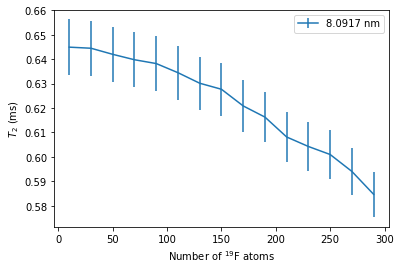

In [6]:

conc = np.arange(1e20,3.1e21,2e20)
num = np.arange(10,301,20)


#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################
# T2_F_near = []
# T2_err_F_near = []
# for j in conc:
#     starttime = time.perf_counter()
#     ''' generate layer of 10-300 hydrogens within a thin 10x10x1 nm^3 layer '''
#     fluorine_layer = pc.random_bath('19F', [1e2, 1e2, 10], 
#                                         density=j, density_units='cm-3', 
#                                         center=[50,50,60], seed=seed)
    
#     ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
#     # Generate unitcell from ase
#     diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
#     diamond.zdir = [1,1,1]
    
#     # Add types of isotopes
#     diamond.add_isotopes(('13C', 0.011))
    
#     # Add the defect. remove and add atoms at the positions (in cell coordinates) 
#     atoms = diamond.gen_supercell(100, remove=[('C', [-5, -5, -5]),('C', [-5+0.5, -5+0.5, -5+0.5])],
#                                   add=('14N', [-5+0.5, -5+0.5, -5+0.5]), seed=seed)
    
#     """setup for coherence calculation"""
    
#     # Parameters of CCE calculations engine
    
#     # Order of CCE aproximation
#     order = 2
#     # Bath cutoff radius
#     r_bath = 150  # in A
#     # Cluster cutoff radius
#     r_dipole = 50  # in A
    
#     # Qubit levels (in Sz basis)
#     alpha = [0, 0, 1]; beta = [0, 1, 0]
    
#     # ZFS Parametters of NV center in diamond
#     D = 2.88 * 1e6 # in kHz
#     E = 0 # in kHz
    
#     # position of central spin
#     position = [-5,-5,-5]
    
#     # generate central spin
#     nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
#     # Setting the runner engine
#     calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,fluorine_layer]),
#                         r_bath=r_bath, r_dipole=r_dipole, order=order)
    
#     ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#     "coherence calculation"
    
#     "general"
#     # Time points
#     time_space = np.linspace(0, 3, 201)  # in ms
    
#     # Mag. Field (Bx By Bz)
#     b = np.array([0,0,500])  # in G
    
#     # Hahn-echo pulse sequence
#     pulse_sequence = [pc.Pulse('x', np.pi)]
    
#     # Calculate coherence function with general method
#     l_generatilze = calc.compute(time_space, magnetic_field=b,
#                                  pulses=pulse_sequence,
#                                  method='gcce', quantity='coherence')
    
#     ''' filter faulty points '''
#     l_generatilze_test = l_generatilze.real
    
#     time_space_generatilze_fixed = []
#     l_generatilze_fixed = []
#     for i in np.arange(0,201):
#         if l_generatilze_test[i] < 1.25:
#             l_generatilze_fixed.append(l_generatilze_test[i])
#             time_space_generatilze_fixed.append(time_space[i])
    
    
#     ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#     "fitting a negative squared exponential"
#     def coherence_fit(x,T2):
#         "fit coherence function to a negative squared exponential function with time constant T2"
#         fit = np.exp(-(x/T2)**2)
#         return fit
    
#     #popt: Optimized parameters
#     #pcov: matrix of covariance.
#     T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
#     T2_var = np.sqrt(np.abs(T2_var))
    
#     T2_F_near.append(T2_gen[0])
#     T2_err_F_near.append(T2_var[0][0])
#     endtime = time.perf_counter()
#     print(starttime-endtime)
    
# # plots the data points and the fitted  curve
# plt.figure()
# plt.errorbar(num, T2_F_near, yerr=T2_err_F_near, label='1.9083 nm')
# plt.legend()
# plt.xlabel('Number of $^{19}$F atoms')
# plt.ylabel('$T_2$ (ms)')

#######################################################################################################################
########## depth = 5.0 nm ##########
#######################################################################################################################
# T2_F_mid = []
# T2_err_F_mid = []
# for j in conc:
#     starttime = time.perf_counter()
#     ''' generate layer of 10-300 hydrogens within a thin 10x10x1 nm^3 layer '''
#     fluorine_layer = pc.random_bath('19F', [1e2, 1e2, 10], 
#                                         density=j, density_units='cm-3', 
#                                         center=[50,50,60], seed=seed)
    
#     ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
#     # Generate unitcell from ase
#     diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
#     diamond.zdir = [1,1,1]
    
#     # Add types of isotopes
#     diamond.add_isotopes(('13C', 0.011))
    
#     # Add the defect. remove and add atoms at the positions (in cell coordinates) 
#     atoms = diamond.gen_supercell(100, remove=[('C', [0, 0, 0]),('C', [0+0.5, 0+0.5, 0+0.5])],
#                                   add=('14N', [0+0.5, 0+0.5, 0+0.5]), seed=seed)
    
#     """setup for coherence calculation"""
    
#     # Parameters of CCE calculations engine
    
#     # Order of CCE aproximation
#     order = 2
#     # Bath cutoff radius
#     r_bath = 150  # in A
#     # Cluster cutoff radius
#     r_dipole = 50  # in A
    
#     # Qubit levels (in Sz basis)
#     alpha = [0, 0, 1]; beta = [0, 1, 0]
    
#     # ZFS Parametters of NV center in diamond
#     D = 2.88 * 1e6 # in kHz
#     E = 0 # in kHz
    
#     # position of central spin
#     position = [0,0,0]
    
#     # generate central spin
#     nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
#     # Setting the runner engine
#     calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,fluorine_layer]),
#                         r_bath=r_bath, r_dipole=r_dipole, order=order)
    
#     ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#     "coherence calculation"
    
#     "general"
#     # Time points
#     time_space = np.linspace(0, 3, 201)  # in ms
    
#     # Mag. Field (Bx By Bz)
#     b = np.array([0,0,500])  # in G
    
#     # Hahn-echo pulse sequence
#     pulse_sequence = [pc.Pulse('x', np.pi)]
    
#     # Calculate coherence function with general method
#     l_generatilze = calc.compute(time_space, magnetic_field=b,
#                                  pulses=pulse_sequence,
#                                  method='gcce', quantity='coherence')
    
#     ''' filter faulty points '''
#     l_generatilze_test = l_generatilze.real
    
#     time_space_generatilze_fixed = []
#     l_generatilze_fixed = []
#     for i in np.arange(0,201):
#         if l_generatilze_test[i] < 1.25:
#             l_generatilze_fixed.append(l_generatilze_test[i])
#             time_space_generatilze_fixed.append(time_space[i])
    
    
#     ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#     "fitting a negative squared exponential"
#     def coherence_fit(x,T2):
#         "fit coherence function to a negative squared exponential function with time constant T2"
#         fit = np.exp(-(x/T2)**2)
#         return fit
    
#     #popt: Optimized parameters
#     #pcov: matrix of covariance.
#     T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
#     T2_var = np.sqrt(np.abs(T2_var))
    
#     T2_F_mid.append(T2_gen[0])
#     T2_err_F_mid.append(T2_var[0][0])
#     endtime = time.perf_counter()
#     print(starttime-endtime)

# # plots the data points and the fitted  curve
# plt.figure()
# plt.errorbar(num, T2_F_mid , yerr=T2_err_F_mid , label='5.0 nm')
# plt.legend()
# plt.xlabel('Number of $^{19}$F atoms')
# plt.ylabel('$T_2$ (ms)')
#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################
T2_F_far = []
T2_err_F_far = []
n = 0
for j in conc:
    n = n+1
    starttime = time.perf_counter()
    ''' generate layer of 10-300 hydrogens within a thin 10x10x1 nm^3 layer '''
    fluorine_layer = pc.random_bath('19F', [1e2, 1e2, 10], 
                                        density=j, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [5, 5, 5]),('C', [5+0.5, 5+0.5, 5+0.5])],
                                  add=('14N', [5+0.5, 5+0.5, 5+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [5,5,5]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,fluorine_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 3, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_F_far.append(T2_gen[0])
    T2_err_F_far.append(T2_var[0][0])
    endtime = time.perf_counter()
    print(starttime-endtime,"secs for calc",n)

# plots the data points and the fitted  curve
plt.figure()
plt.errorbar(num, T2_F_far , yerr=T2_err_F_far , label='8.0917 nm')
plt.legend()
plt.xlabel('Number of $^{19}$F atoms')
plt.ylabel('$T_2$ (ms)')

# plots the data points and the fitted  curve
# plt.figure()
# plt.errorbar(num, T2_F_near, yerr=T2_err_F_near, label='1.9083 nm')
# plt.errorbar(num, T2_F_mid , yerr=T2_err_F_mid , label='5.0 nm')
# plt.errorbar(num, T2_F_far , yerr=T2_err_F_far , label='8.0917 nm')
# plt.legend()
# plt.xlabel('Number of $^{19}$F atoms')
# plt.ylabel('$T_2$ (ms)')


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Text(0, 0.5, '$T_2$ (ms)')

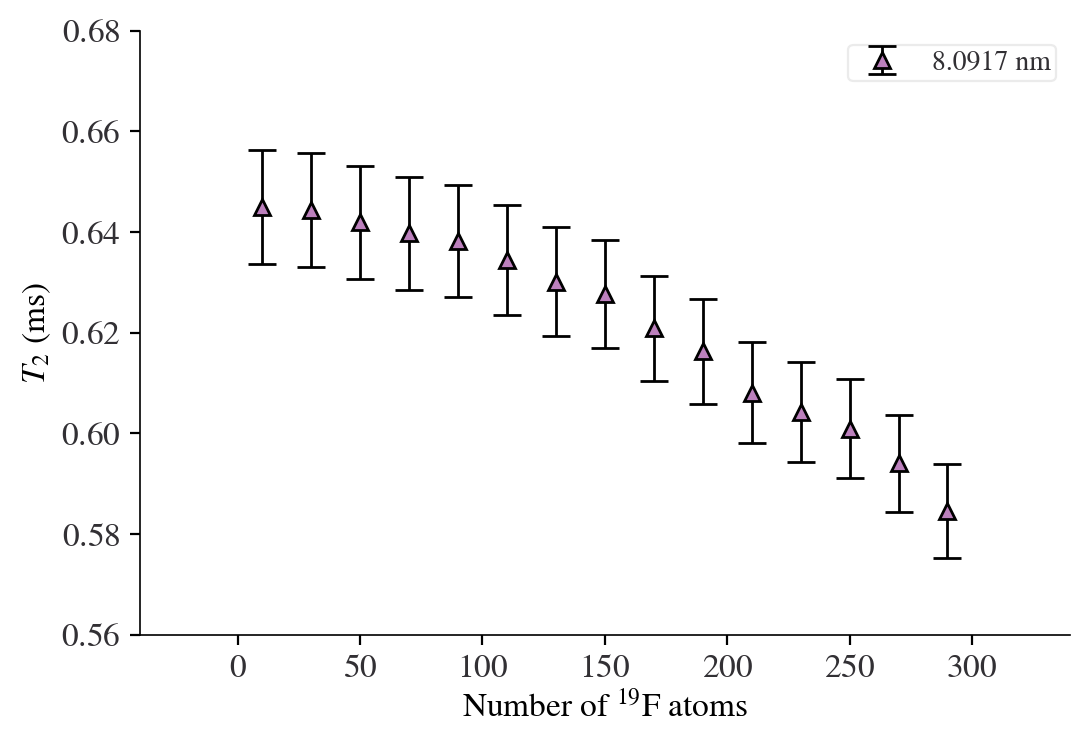

In [60]:
plt.style.use('plot_style.txt')
num = np.arange(10,301,20)

def inversecube_function(x,C):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = C*(x**3)
        return fit

C_far,C_far_var = curve_fit(inversecube_function,num, T2_F_far)
C_far_err = np.sqrt(np.abs(C_far_var))

num_fit = np.arange(10,311,1)

plt.figure()
# plt.errorbar(num, T2_F_near, yerr=T2_err_F_near, label='1.9083 nm')
# plt.errorbar(num, T2_F_mid , yerr=T2_err_F_mid , label='5.0 nm')
plt.errorbar(num, T2_F_far , yerr=T2_err_F_far ,fmt='^', ecolor='k', elinewidth=1, capsize=5, label='8.0917 nm')
# plt.plot(num_fit, inversecube_function(num_fit,C_far), label='$C_far$ = {0:0.3f} $\pm$ {1:0.3f}'.format(C_far[0],C_far_err[0][0]))
plt.legend()
plt.xlim(-40,340)
plt.xlabel('Number of $^{19}$F atoms')
plt.ylabel('$T_2$ (ms)')

KeyboardInterrupt: 

<Figure size 2000x1800 with 0 Axes>

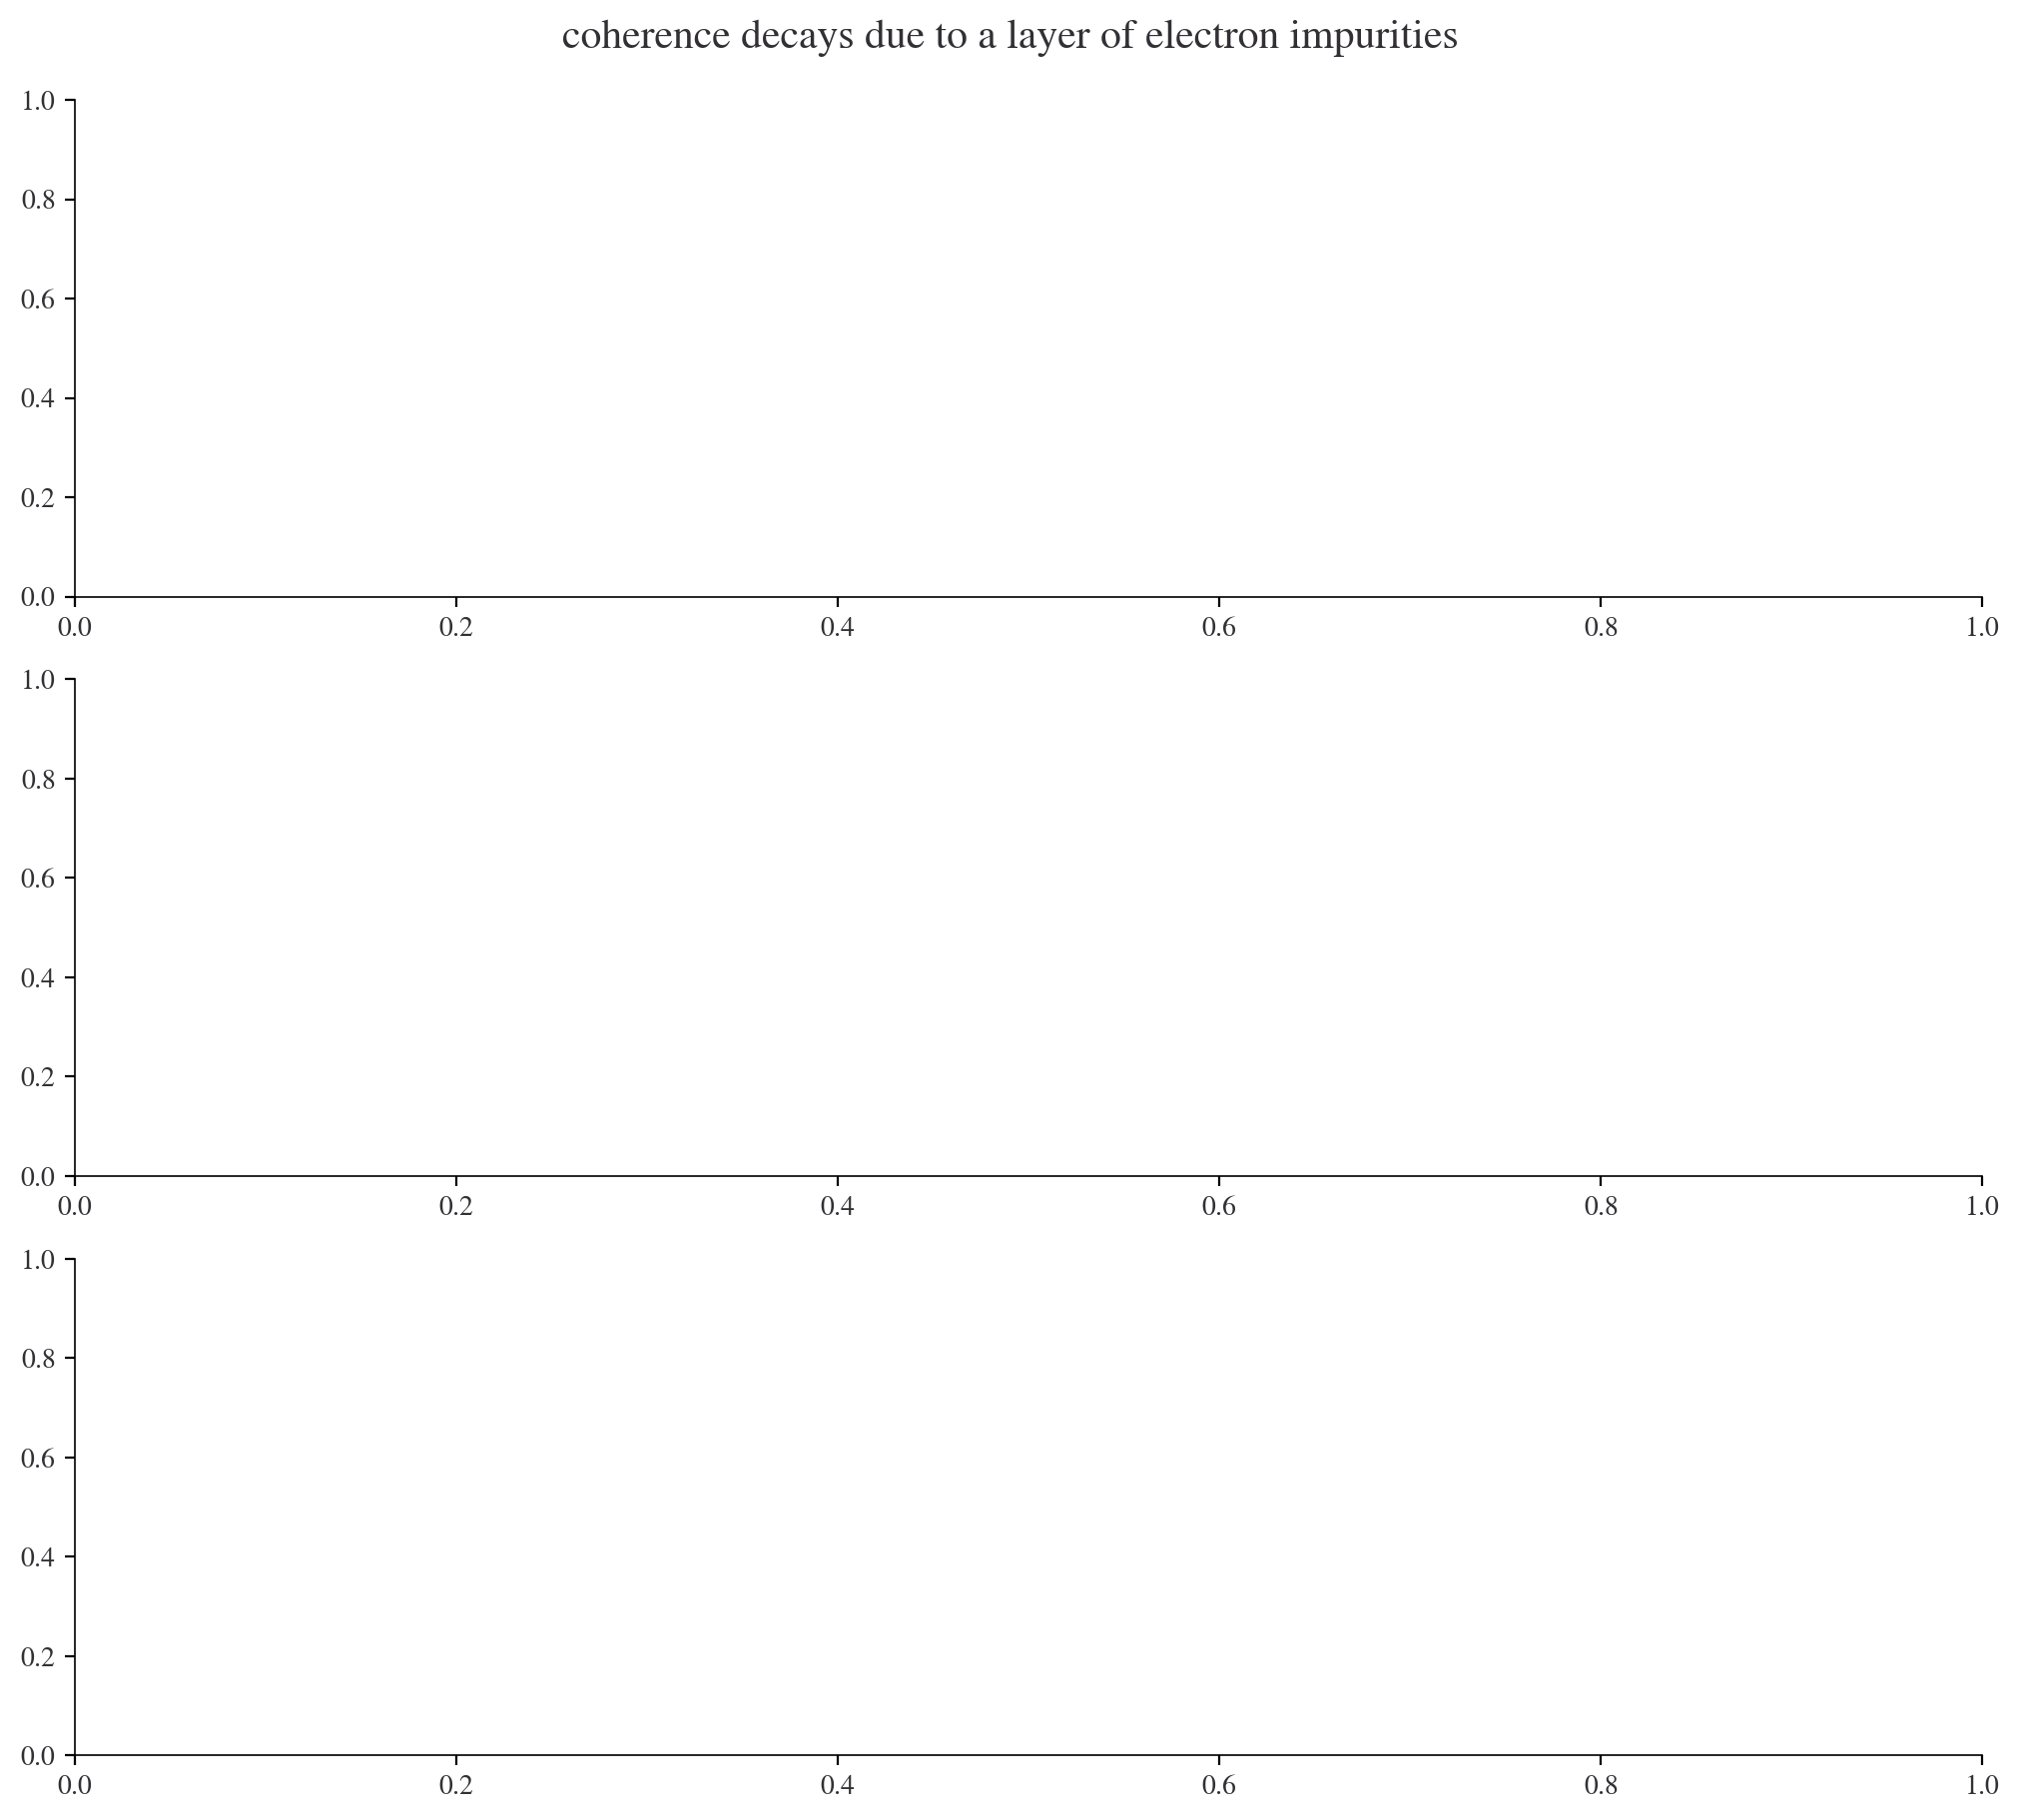

In [10]:
''' import libraries '''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import ase
import warnings
from mpl_toolkits import mplot3d
from ase.build import bulk
import pycce.filter
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib as mpl
import time

"""set up seed for bath generations"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=10)

# plt.style.use('plot_style.txt')
# plt.style.use('plot_style.txt')
mpl.rcParams['figure.figsize'] = [10.0, 9.0]
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['axes.labelsize'] = 10.0

plt.figure()
fig, axes = plt.subplots(3,1, constrained_layout = True)
fig.suptitle('coherence decays due to a layer of electron impurities', size=15)


#######################################################################################################################
########## depth = 8.0917 nm ##########
#######################################################################################################################

starttime = time.perf_counter()

''' generate layer of 80 electrons within a thin 10x10x1 nm^3 layer '''
electron_10_sparse = pc.random_bath('e', [1e2, 1e2, 10], density=2e20,
                        density_units='cm-3', center=[50,50,60], seed=seed)


''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [5, 5, 5]),
                                               ('C', [5+0.5, 5+0.5, 5+0.5])],
                                  add=('14N', [5+0.5, 5+0.5, 5+0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 150  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [5,5,5]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_10_sparse]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 0.1, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_far = []
l_generatilze_fixed_far = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
        l_generatilze_fixed_far.append(l_generatilze_test[i])
        time_space_generatilze_fixed_far.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_far,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_far, l_generatilze_fixed_far)
T2_var_far = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_far = coherence_fit(time_space_generatilze_fixed_far, T2_gen_far)

axes[0].plot(time_space_generatilze_fixed_far, l_generatilze_fixed_far, label='8.092 nm', ls='-')
axes[0].plot(time_space_generatilze_fixed_far, y_gen_far, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_far[0],T2_var_far[0][0]))
axes[0].set_xlabel('Time ($ms$)')
axes[0].set_ylabel('Coherence')
axes[0].legend()

endtime = time.perf_counter()
print(starttime-endtime,"seconds taken for calc 1")

#######################################################################################################################
########## depth = 5 nm ##########
#######################################################################################################################

starttime = time.perf_counter()

''' generate layer of 80 electrons within a thin 10x10x1 nm^3 layer '''
electron_10_sparse = pc.random_bath('e', [1e2, 1e2, 10], density=2e20,
                        density_units='cm-3', center=[50,50,60], seed=seed)


''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [0, 0, 0]),
                                               ('C', [0+0.5, 0+0.5, 0+0.5])],
                                  add=('14N', [0+0.5, 0+0.5, 0+0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 150  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [0,0,0]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_10_sparse]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 0.1, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_mid = []
l_generatilze_fixed_mid = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
        l_generatilze_fixed_mid.append(l_generatilze_test[i])
        time_space_generatilze_fixed_mid.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_mid,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_mid, l_generatilze_fixed_mid)
T2_var_mid = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_mid = coherence_fit(time_space_generatilze_fixed_mid, T2_gen_mid)

axes[1].plot(time_space_generatilze_fixed_mid, l_generatilze_fixed_mid, label='5.0 nm', ls='-')
axes[1].plot(time_space_generatilze_fixed_mid, y_gen_mid, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_mid[0],T2_var_mid[0][0]))
axes[1].set_xlabel('Time ($ms$)')
axes[1].set_ylabel('Coherence')
axes[1].legend()

endtime = time.perf_counter()
print(starttime-endtime,"seconds for calc 2")

#######################################################################################################################
########## depth = 1.9083 nm ##########
#######################################################################################################################

starttime = time.perf_counter()

''' generate layer of 80 electrons within a thin 10x10x1 nm^3 layer '''
electron_10_sparse = pc.random_bath('e', [1e2, 1e2, 10], density=2e20,
                        density_units='cm-3', center=[50,50,60], seed=seed)


''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [-5, -5, -5]),
                                               ('C', [-5+0.5, -5+0.5, -5+0.5])],
                                  add=('14N', [-5+0.5, -5+0.5, -5+0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 150  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [-5,-5,-5]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_10_sparse]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 0.1, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_near = []
l_generatilze_fixed_near = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
        l_generatilze_fixed_near.append(l_generatilze_test[i])
        time_space_generatilze_fixed_near.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_near,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_near, l_generatilze_fixed_near)
T2_var_near = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_near = coherence_fit(time_space_generatilze_fixed_near, T2_gen_near)

axes[2].plot(time_space_generatilze_fixed_near, l_generatilze_fixed_near, label='1.9083 nm', ls='-')
axes[2].plot(time_space_generatilze_fixed_near, y_gen_near, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_near[0],T2_var_near[0][0]))
axes[2].set_xlabel('Time ($ms$)')
axes[2].set_ylabel('Coherence')
axes[2].legend()

endtime = time.perf_counter()
print(starttime-endtime,"seconds for calc 3")

plt.figure()
fig, axes = plt.subplots(3,1, constrained_layout = True)
fig.suptitle('coherence decays due to a layer of electron impurities', size=15)

axes[0].plot(time_space_generatilze_fixed_far, l_generatilze_fixed_far, label='8.092 nm', ls='-')
axes[0].plot(time_space_generatilze_fixed_far, y_gen_far, '-', label='$T_2$ = {0:0.5f}$\pm${1:0.3f} ms'.format(T2_gen_far[0],T2_var_far[0][0]))
axes[0].set_xlabel('Time ($ms$)')
axes[0].set_ylabel('Coherence')
axes[0].legend()

axes[1].plot(time_space_generatilze_fixed_mid, l_generatilze_fixed_mid, label='5.0 nm', ls='-')
axes[1].plot(time_space_generatilze_fixed_mid, y_gen_mid, '-', label='$T_2$ = {0:0.5f}$\pm${1:0.3f} ms'.format(T2_gen_mid[0],T2_var_mid[0][0]))
axes[1].set_xlabel('Time ($ms$)')
axes[1].set_ylabel('Coherence')
axes[1].legend()

axes[2].plot(time_space_generatilze_fixed_near, l_generatilze_fixed_near, label='1.9083 nm', ls='-')
axes[2].plot(time_space_generatilze_fixed_near, y_gen_near, '-', label='$T_2$ = {0:0.5f}$\pm${1:0.3f} ms'.format(T2_gen_near[0],T2_var_near[0][0]))
axes[2].set_xlabel('Time ($ms$)')
axes[2].set_ylabel('Coherence')
axes[2].legend()


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<Figure size 2000x1800 with 0 Axes>

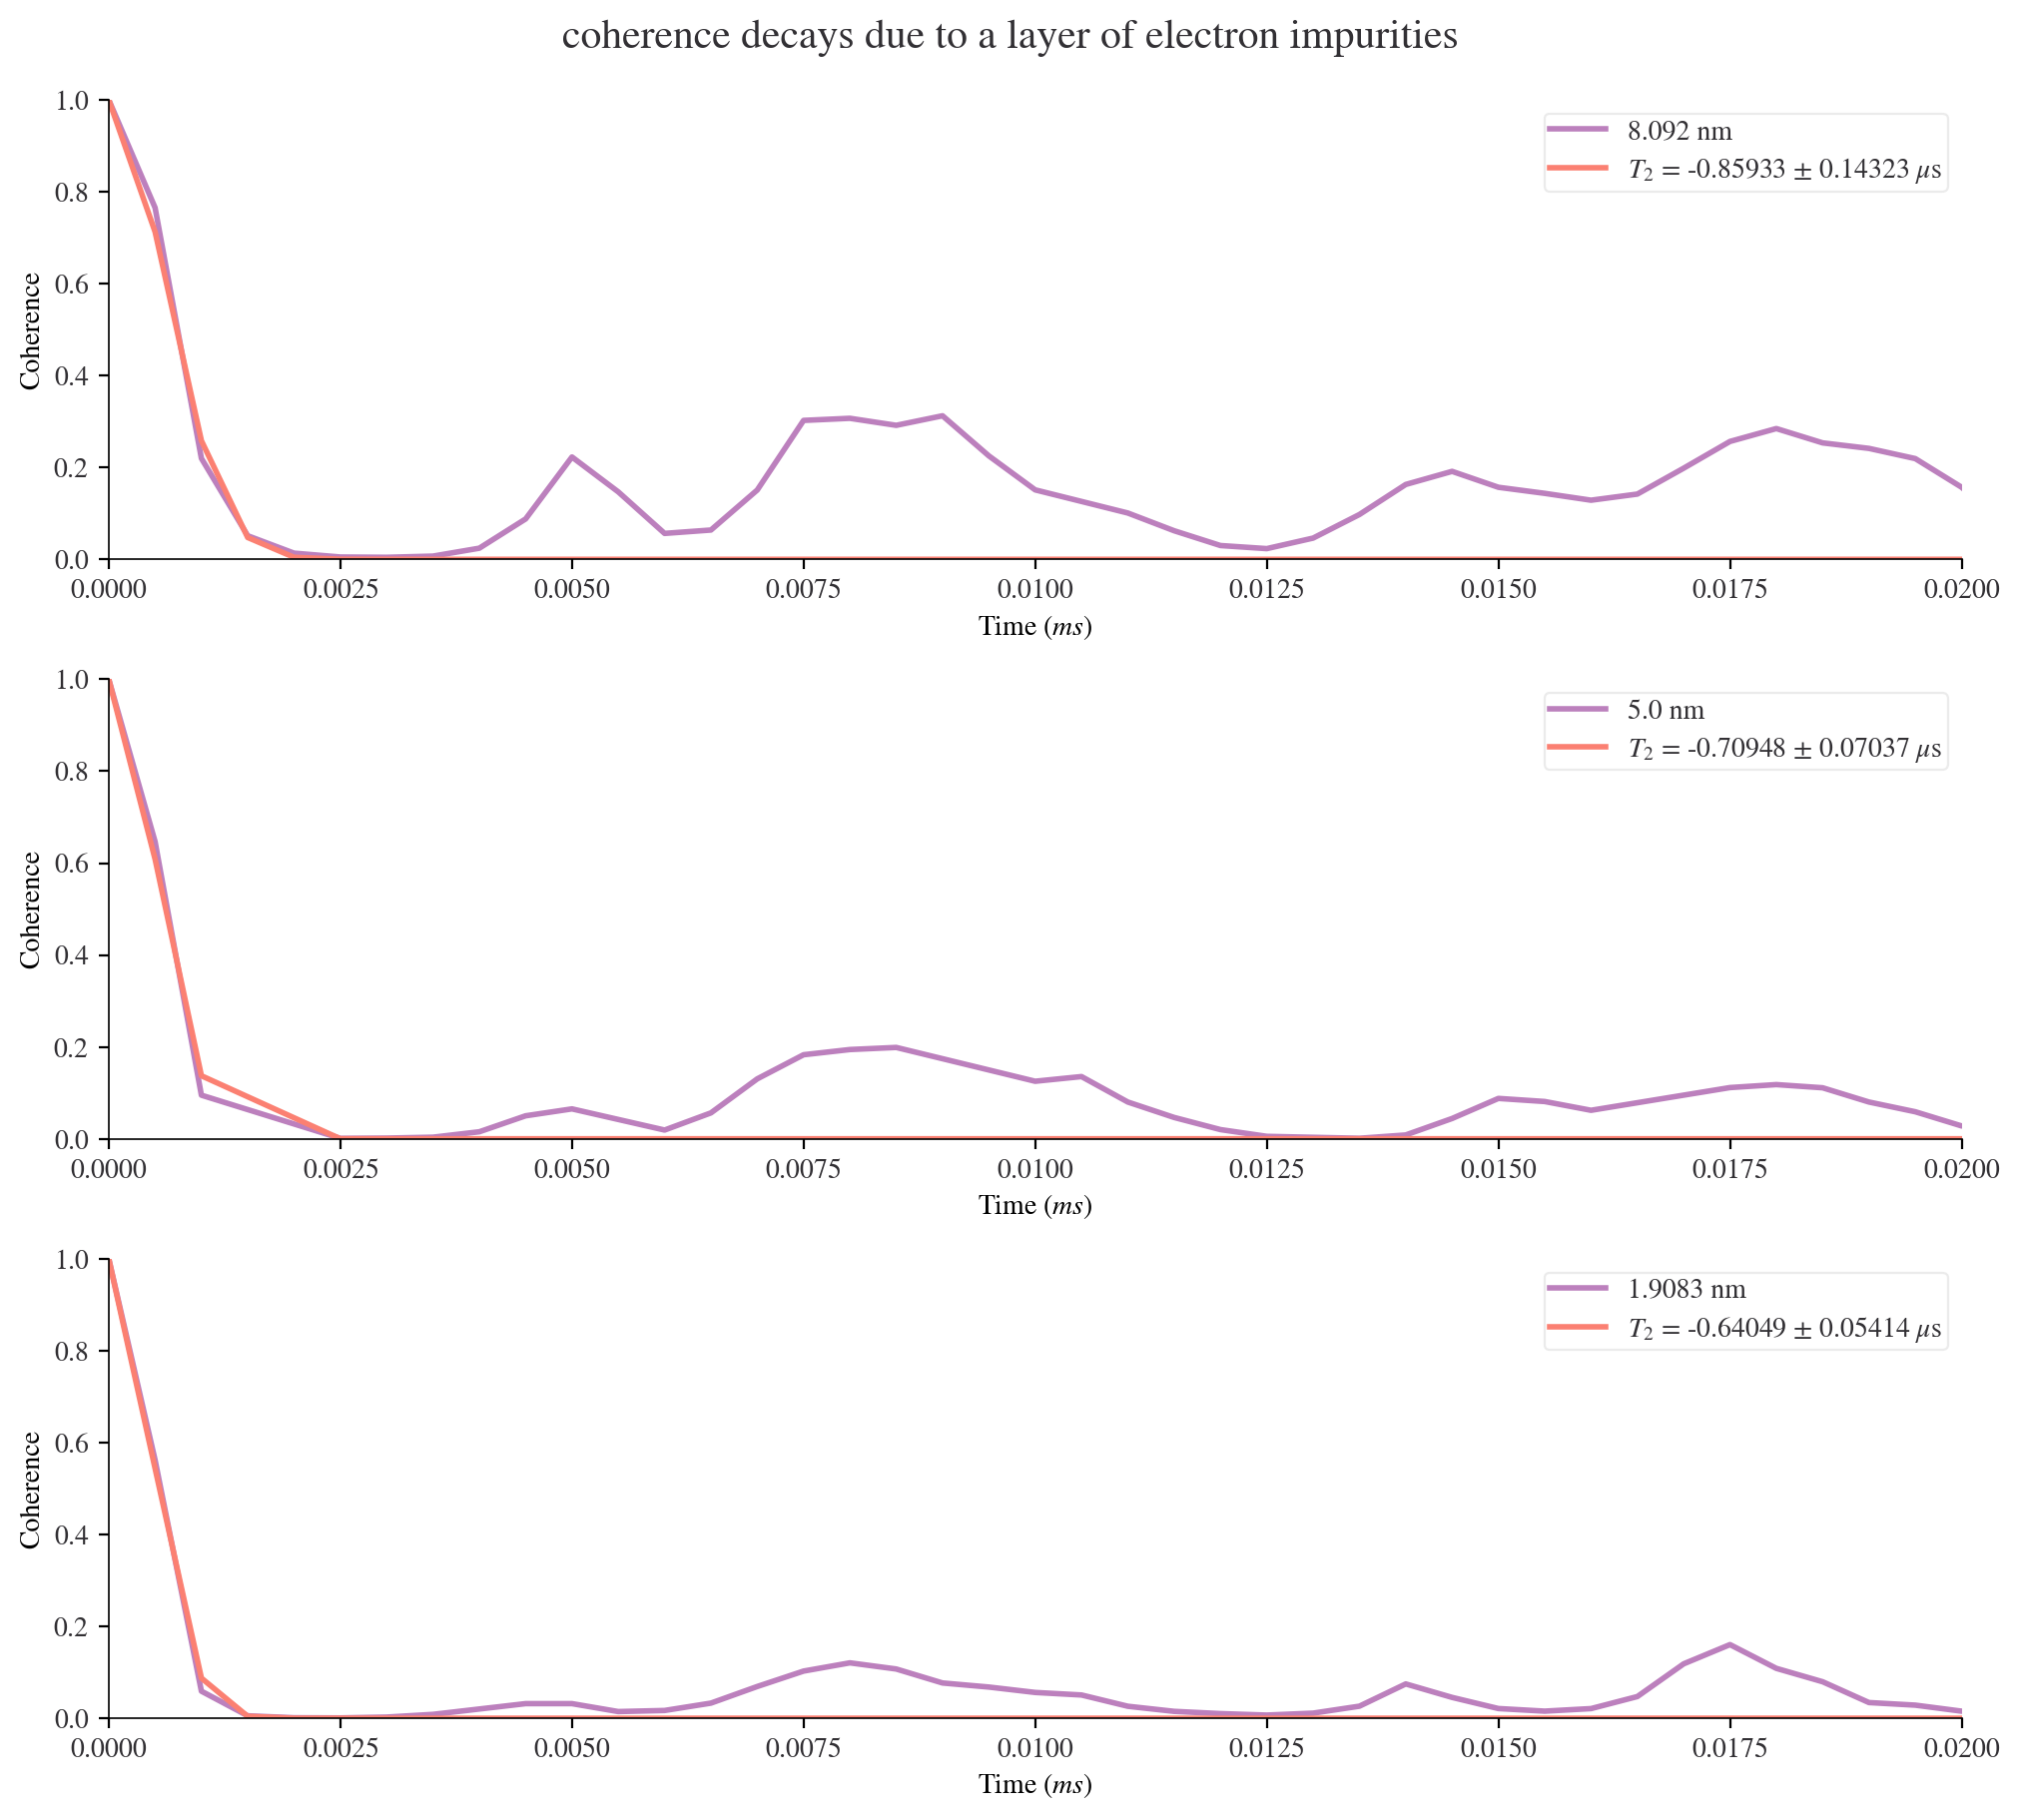

In [19]:
plt.style.use('plot_style.txt')

mpl.rcParams['figure.figsize'] = [10.0, 9.0]
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['axes.labelsize'] = 10.0

plt.figure()
fig, axes = plt.subplots(3,1, constrained_layout = True)
fig.suptitle('coherence decays due to a layer of electron impurities', size=15)

axes[0].plot(time_space_generatilze_fixed_far, l_generatilze_fixed_far, label='8.092 nm', ls='-')
axes[0].plot(time_space_generatilze_fixed_far, y_gen_far, '-', label='$T_2$ = {0:0.5f} $\pm$ {1:0.5f} $\mu$s'.format(T2_gen_far[0]*1000,T2_var_far[0][0]*1000))
axes[0].set_xlabel('Time ($ms$)')
axes[0].set_ylabel('Coherence')
axes[0].set_xlim(0,0.02)
axes[0].set_ylim(0,1)
axes[0].legend()

axes[1].plot(time_space_generatilze_fixed_mid, l_generatilze_fixed_mid, label='5.0 nm', ls='-')
axes[1].plot(time_space_generatilze_fixed_mid, y_gen_mid, '-', label='$T_2$ = {0:0.5f} $\pm$ {1:0.5f} $\mu$s'.format(T2_gen_mid[0]*1000,T2_var_mid[0][0]*1000))
axes[1].set_xlabel('Time ($ms$)')
axes[1].set_ylabel('Coherence')
axes[1].set_xlim(0,0.02)
axes[1].set_ylim(0,1)
axes[1].legend()

axes[2].plot(time_space_generatilze_fixed_near, l_generatilze_fixed_near, label='1.9083 nm', ls='-')
axes[2].plot(time_space_generatilze_fixed_near, y_gen_near, '-', label='$T_2$ = {0:0.5f} $\pm$ {1:0.5f} $\mu$s'.format(T2_gen_near[0]*1000,T2_var_near[0][0]*1000))
axes[2].set_xlabel('Time ($ms$)')
axes[2].set_ylabel('Coherence')
axes[2].set_xlim(0,0.02)
axes[2].set_ylim(0,1)
axes[2].legend()